<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

## Timeseries properties and modeling

Week 12 | Lesson 2.1

---

We will be using historical, quarterly unemployment data to examine the modeling of timeseries. Below we will cover:

- "Rolling" statistics through time, such as the rolling mean.
- Exponentially weighted statistics.
- Differences and stationarity.
- Autocorrelation and partial autocorrelation.
- Autoregressive models.
- Moving average models.
- ARMA and ARIMA models.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [17]:
data = pd.read_csv('/Users/kiefer/github-repos/DSI-SF-4/datasets/unemployment_timeseries/seasonally-adjusted-quarterly-us.csv')

In [18]:
data.head(2)

,Quarter,Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993
0,1948Q1,3.733%
1,1948Q2,3.667%


In [19]:
data.dtypes

Quarter                                                                    object
Seasonally adjusted quarterly U.S. unemployment rates from 1948 to 1993    object
dtype: object

In [20]:
data.columns = ['year_quarter','unemployment_rate']
data.dropna(inplace=True)
data['unemployment_rate'] = data['unemployment_rate'].map(lambda x: float(x.replace('%','')))
data.dropna(inplace=True)

In [21]:
data.head(2)

,year_quarter,unemployment_rate
0,1948Q1,3.733
1,1948Q2,3.667


In [22]:
date_vector = pd.to_datetime(data['year_quarter']).dt.to_period('Q')
data.set_index(date_vector, inplace=True)
data.head()

,year_quarter,unemployment_rate
year_quarter,,
1948Q1,1948Q1,3.733
1948Q2,1948Q2,3.667
1948Q3,1948Q3,3.767
1948Q4,1948Q4,3.833
1949Q1,1949Q1,4.667


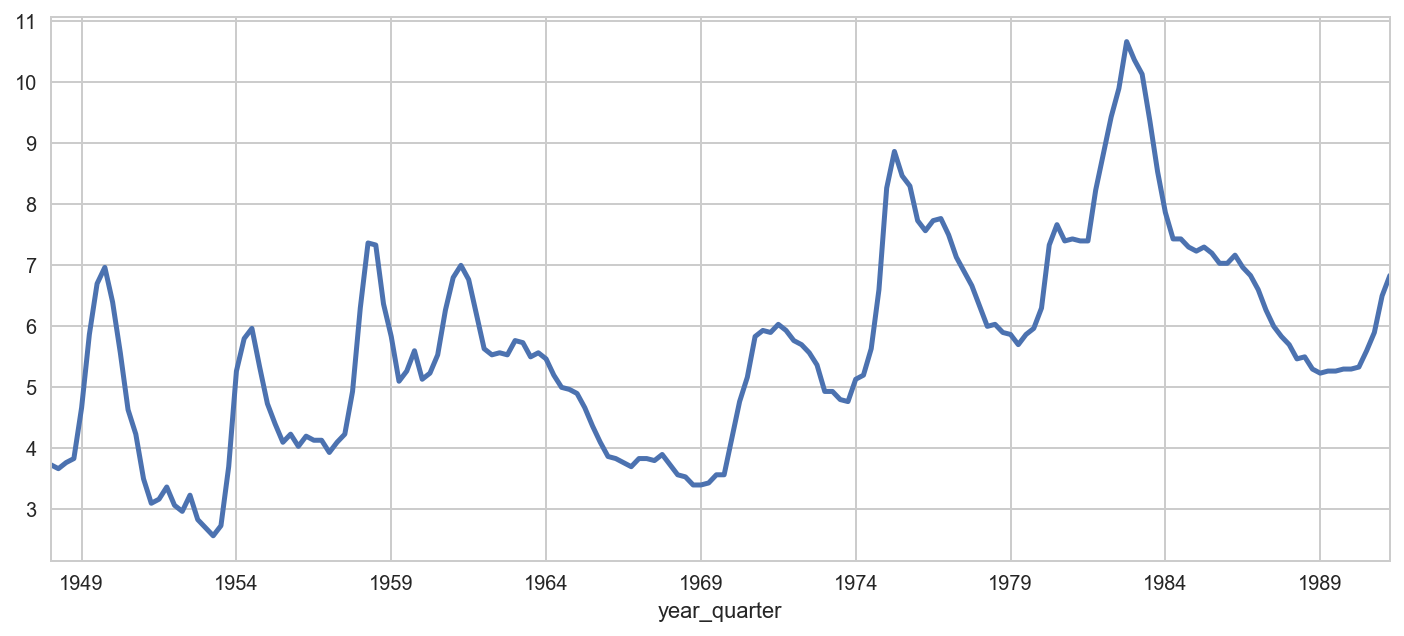

In [23]:
data.unemployment_rate.plot(lw=2.5, figsize=(12,5))

---

### Parameters for `rolling` functions

**`rolling().mean()`** (as well as **`rolling().median()`**) can take these parameters:

- the first is the series to aggregate
- **`window`** is the number of days to include in the average
- **`center`** is whether the window should be centered on the date or use data prior to that date
- **`freq`** is on what level to roll-up the averages to (as used in **`resample`**). Either **`D`** for day, **`M`** for month or **`A`** for year, etc.



http://stackoverflow.com/questions/17001389/pandas-resample-documentation

In [30]:
yearly = data['unemployment_rate'].resample('A').mean()
yearly_roll = yearly.rolling(window=10, center=False).mean()
yearly_roll[0:10]

year_quarter
1948         NaN
1949         NaN
1950         NaN
1951         NaN
1952         NaN
1953         NaN
1954         NaN
1955         NaN
1956         NaN
1957    4.262475
Freq: A-DEC, Name: unemployment_rate, dtype: float64

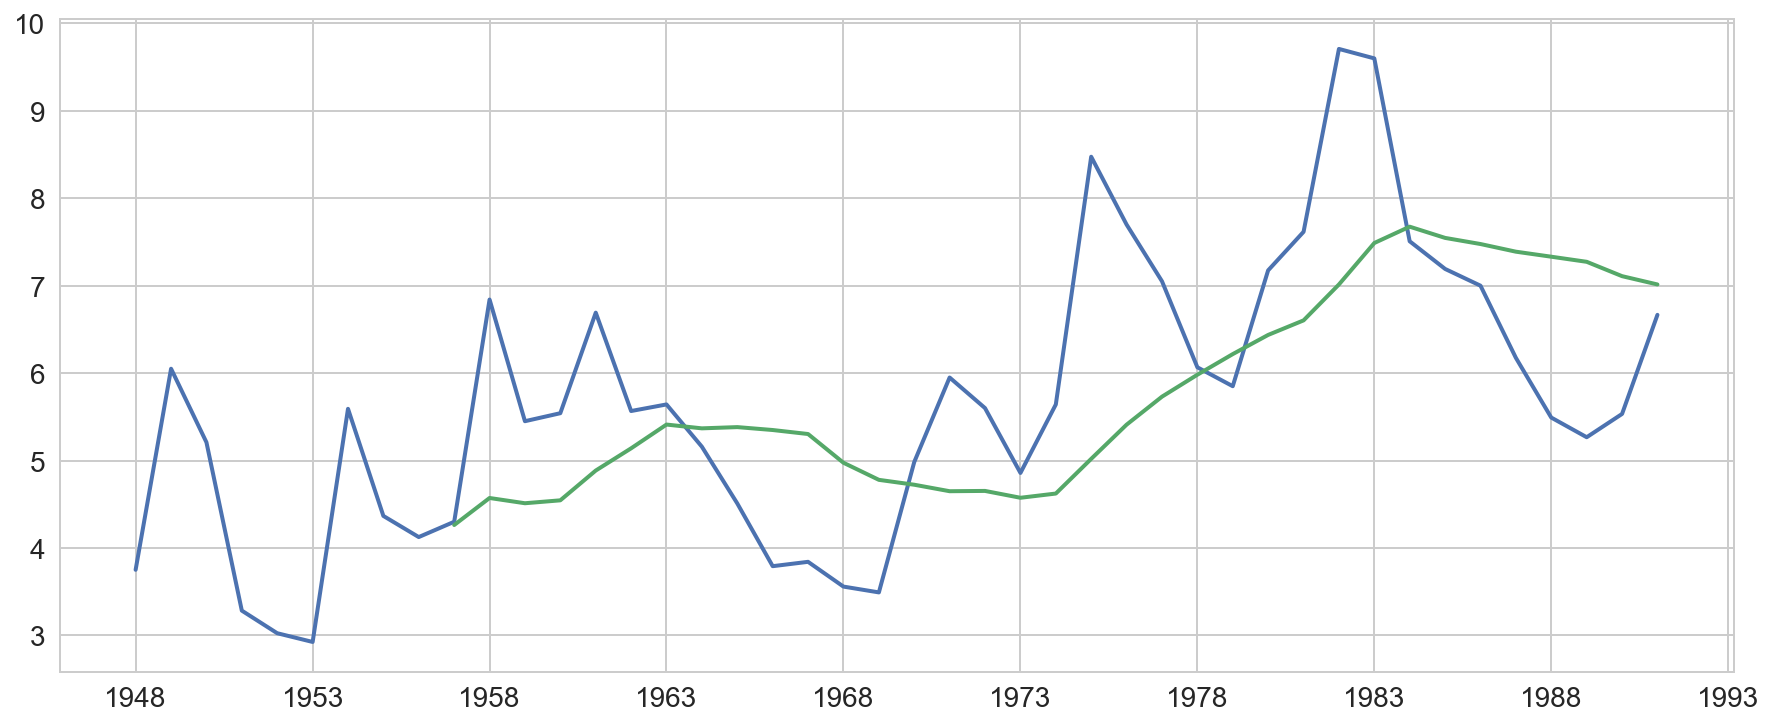

In [31]:
date_ticks = yearly.index.to_timestamp()

plt.figure(figsize=(15,6))
plt.plot(date_ticks, yearly, lw=2)
plt.plot(date_ticks, yearly_roll, lw=2)

plt.tick_params(labelsize=14)

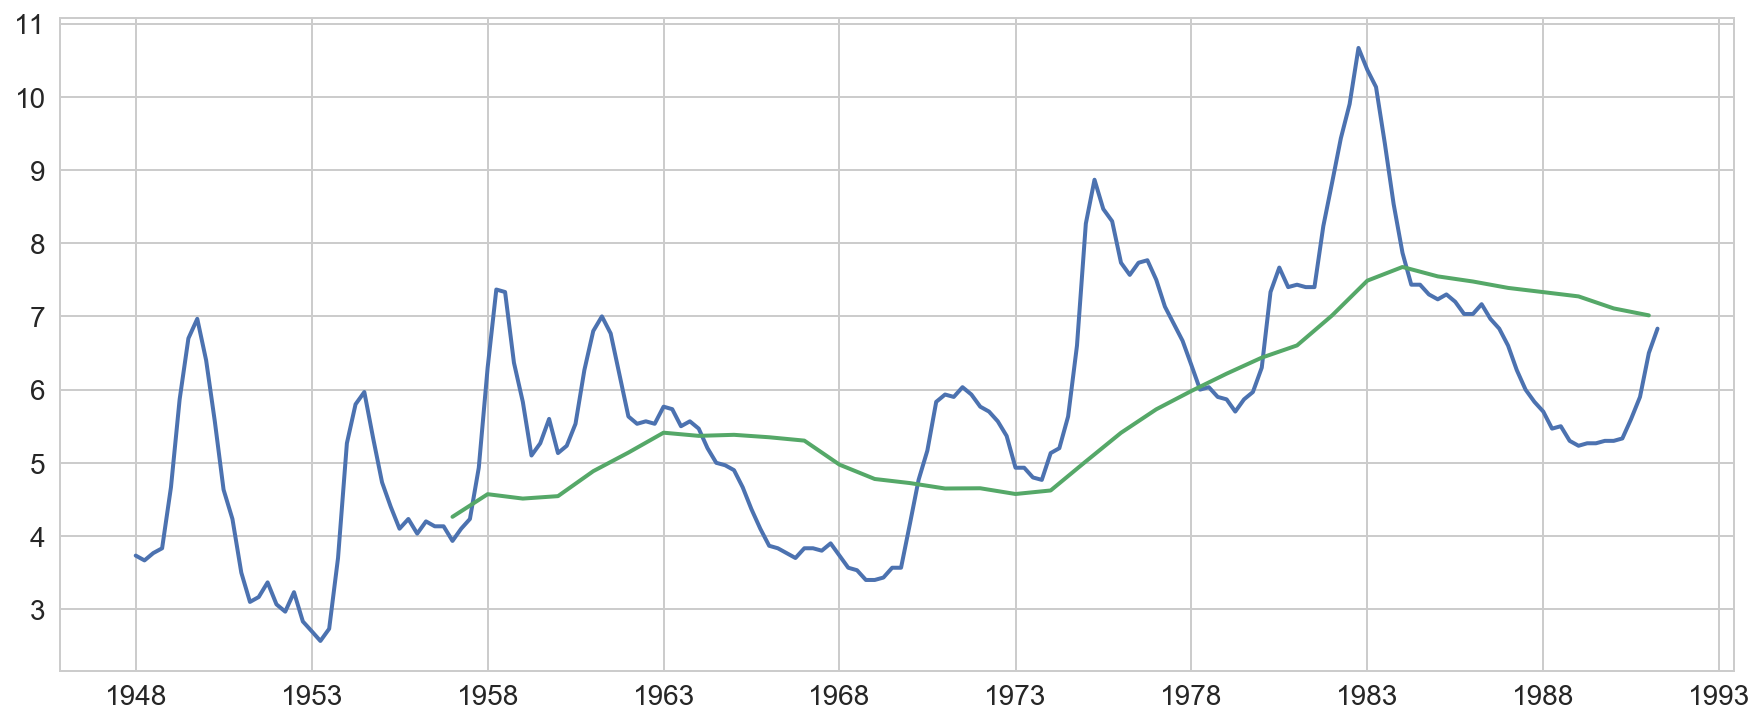

In [32]:
qtr_dates = data.index.to_timestamp()

plt.figure(figsize=(15,6))
plt.plot(qtr_dates, data.unemployment_rate, lw=2)
plt.plot(date_ticks, yearly_roll, lw=2)

plt.tick_params(labelsize=14)

---

### Expanding mean

The "expanding mean" simply uses all datapoints up to the current time to calculate the mean, as opposed to a moving window.

In [33]:
expanding_mean = data.unemployment_rate.expanding().mean()

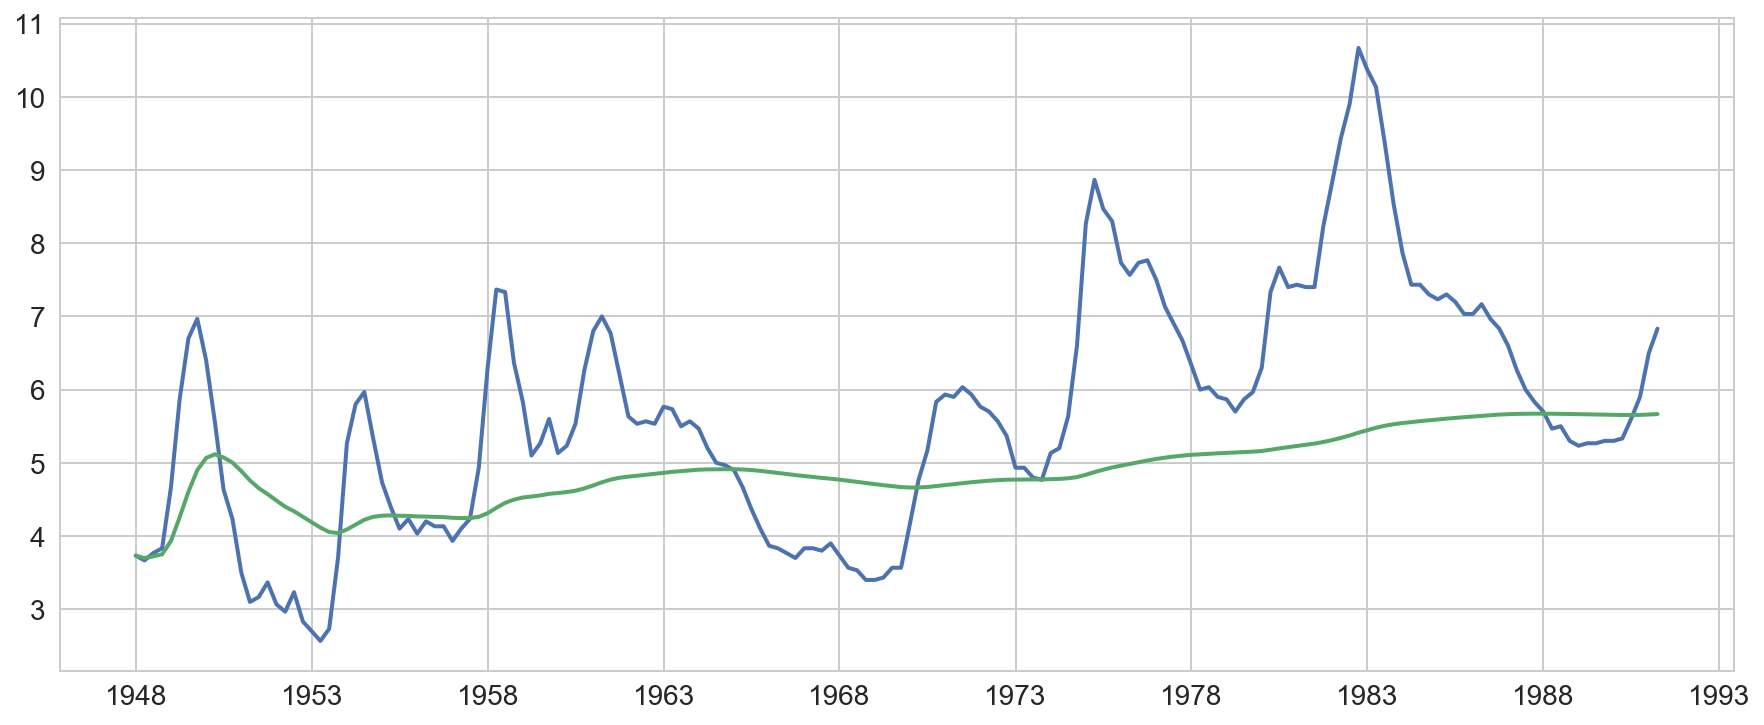

In [34]:
qtr_dates = data.index.to_timestamp()

plt.figure(figsize=(15,6))
plt.plot(qtr_dates, data.unemployment_rate, lw=2)
plt.plot(qtr_dates, expanding_mean, lw=2)

plt.tick_params(labelsize=14)

---

### Exponentially weighted windows

Exponentially weighted windows are one of the most common and effective ways of averaging out noise in timeseries data. The averaging is done with an "exponential decay" on the contribution of prior means, decreasing the contribution of timepoints further in the past.

The (adjusted) exponentially weighted mean for time $t$ is defined as:

### $$ x_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2x_{t-1} + ... + (1 - \alpha)^{t}x_0} {1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^{t}} $$

See:

http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows


In [35]:
# alpha = 1. / (1 + com)
exp_w_mean = data.unemployment_rate.ewm(com=4).mean()

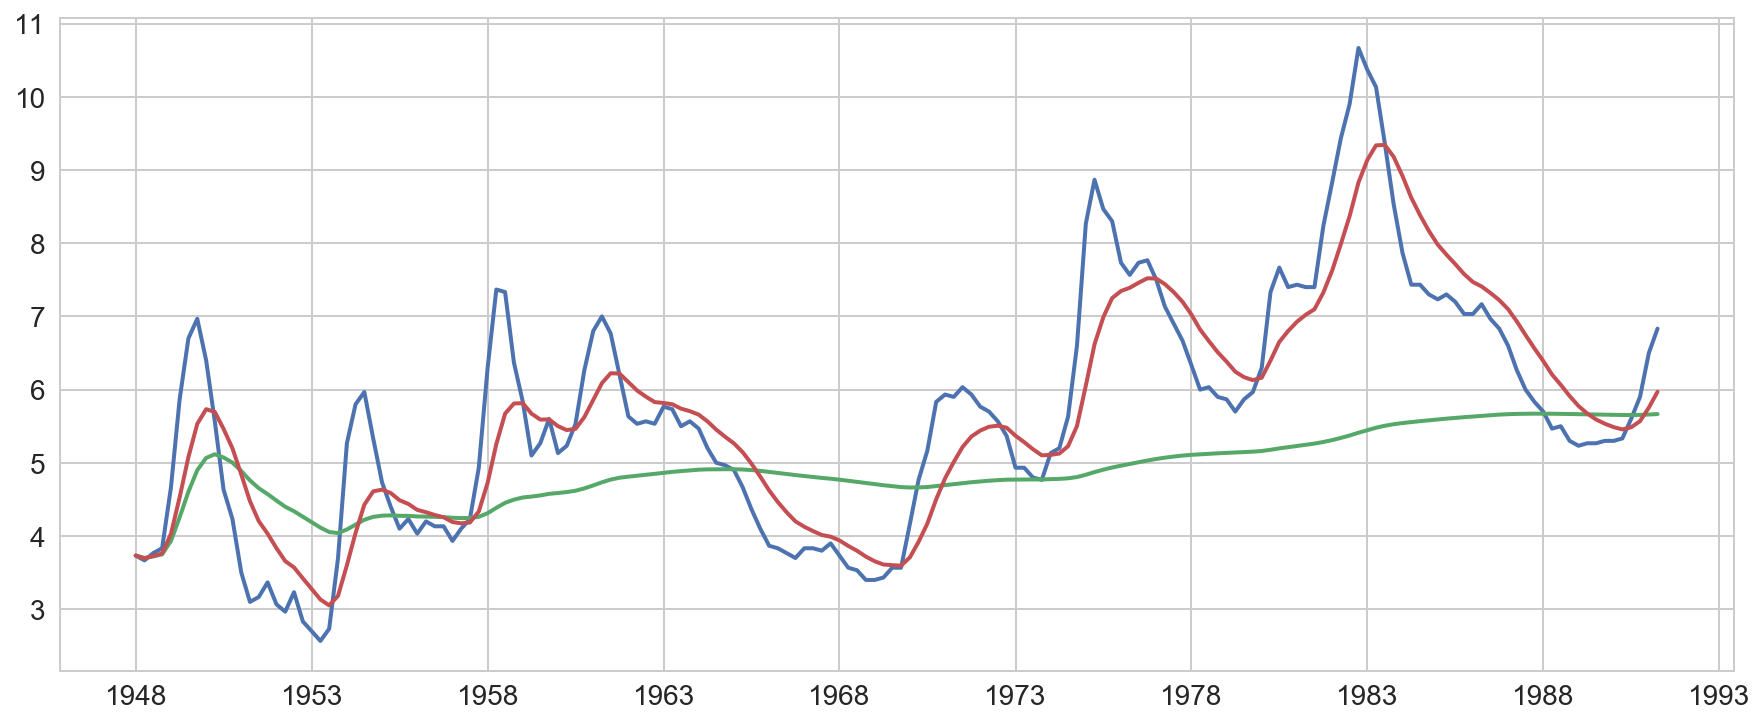

In [36]:
qtr_dates = data.index.to_timestamp()

plt.figure(figsize=(15,6))
plt.plot(qtr_dates, data.unemployment_rate, lw=2)
plt.plot(qtr_dates, expanding_mean, lw=2)
plt.plot(qtr_dates, exp_w_mean, lw=2)

plt.tick_params(labelsize=14)

---

### "Differencing" a timeseries and stationarity

If a time series is stationary, it's mean, variance, and autocorrelation (which is in the next section) are constant over time. Forcasting methods typically assume that the timeseries you are forcasting for is stationary, or at least approximately stationary.

The most common way to make a timeseries stationary is to perform "differencing". This procedure converts a timeseries into the difference between values:

### $$ \Delta y_t = y_t - y_{t-1} $$

This removes trends in the timeseries and ensures that the mean across time is zero. In most cases there will only be a need for a single differencing, although sometimes a second difference (or even more) will be taken to remove trends.

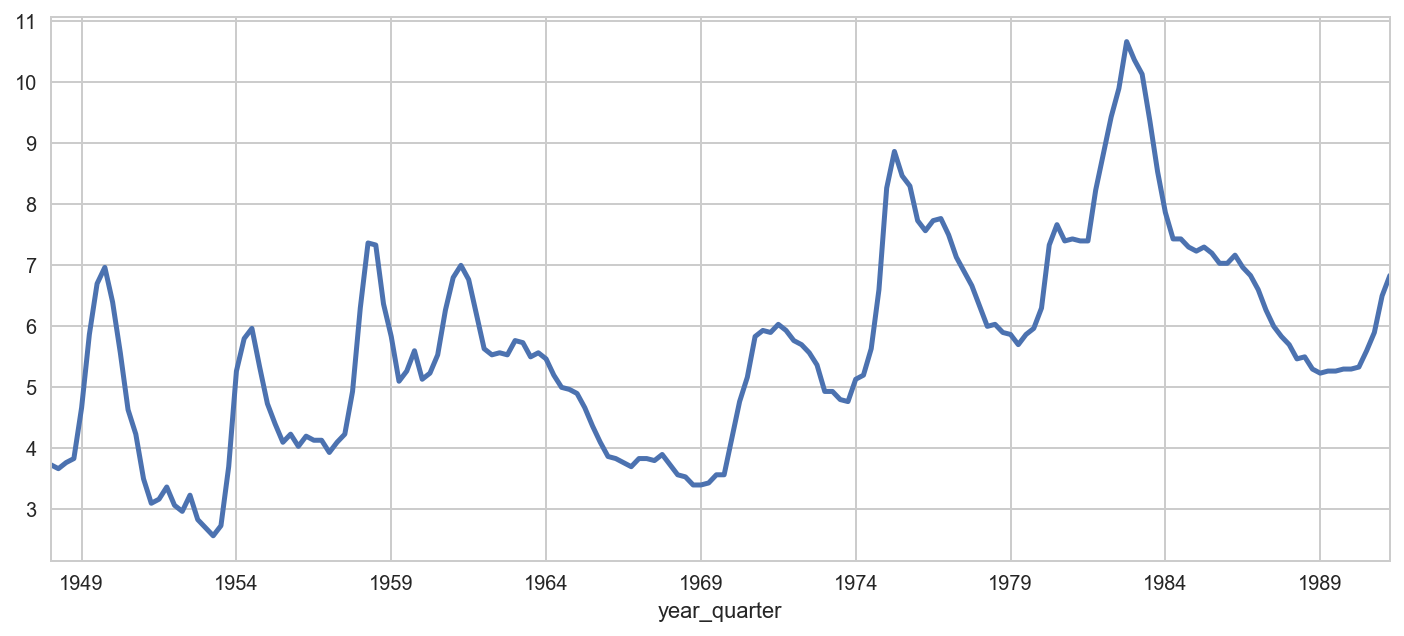

In [37]:
data.unemployment_rate.plot(lw=2.5, figsize=(12,5))

In [38]:
data['udiff'] = data.unemployment_rate.diff()
data.head()

,year_quarter,unemployment_rate,udiff
year_quarter,,,
1948Q1,1948Q1,3.733,NaN
1948Q2,1948Q2,3.667,-0.066
1948Q3,1948Q3,3.767,0.100
1948Q4,1948Q4,3.833,0.066
1949Q1,1949Q1,4.667,0.834


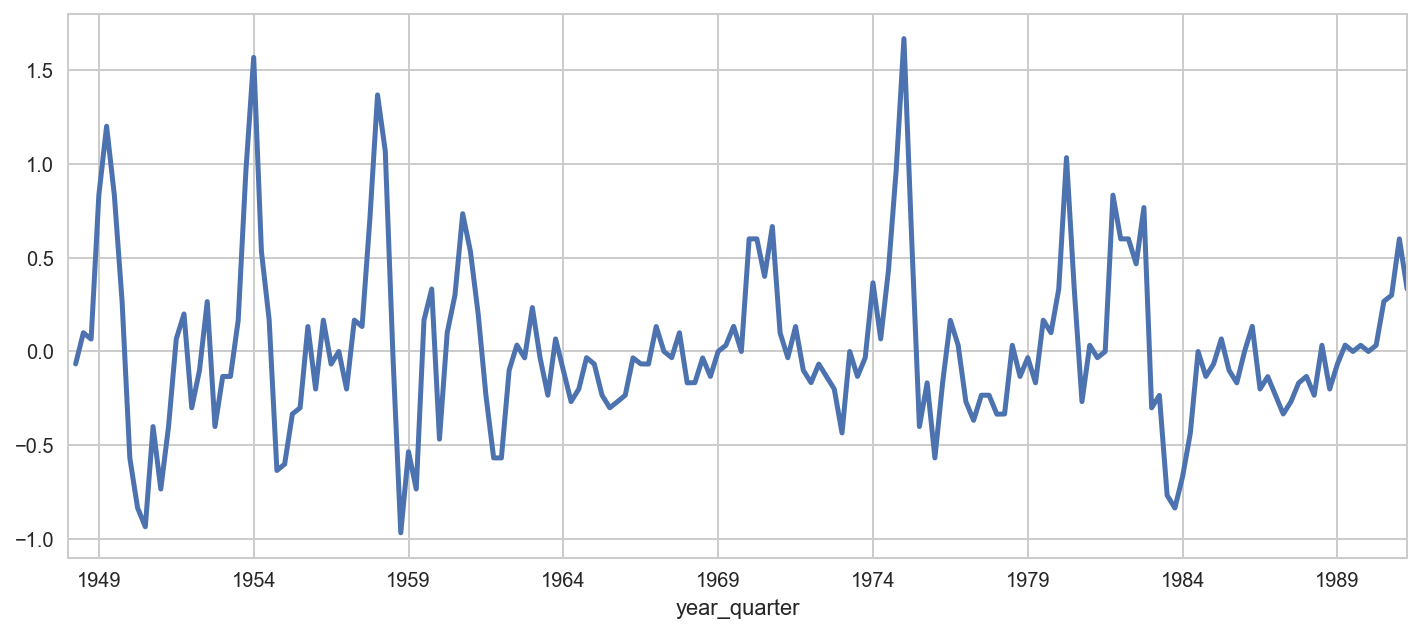

In [39]:
data.udiff.plot(lw=2.5, figsize=(12,5))

---

###  Autocorrelation and the autocorrelation function (ACF)

While in previous weeks, our analyses has been concerned with the correlation between two or more variables (height and weight, education and salary, etc.), in time series data, autocorrelation is a measure of _how correlated a variable is with itself_.

Specifically, autocorrelation measures how closely related earlier values are with values occurring later in time.

Examples of autocorrelation:

    In stock market data the stock price at one point is correlated with the stock 
    price of the point directly prior in time. 
    
    In sales data, sales on a Saturday are likely correlated with 
    sales on the next Saturday and the previous Saturday, as well as other days to more
    or less extent.

Below is the formula for the autocorrelation funtion (acf):

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ at time points } t_1, t_2, t_3 ... t_n:$

### $$lag_k\;acf() = \frac{\sum_{t=k+1}^{n}\left(\;x_t - \bar{x}\;\right)\left(\;x_{t-k} - \bar{x}\;\right)}{\sum_{t=1}^n\left(\;x_t - \bar{x}\;\right)^2}$$

Compare this to the formula for correlation:

$\text{Given measurements } x_1, x_2, x_3 ... x_n \text{ aand measurements } y_1, y_2, y_3 ... y_n:$

### $$r_{xy} = \frac{\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)\left(\;y_{i} - \bar{y}\;\right)}{\sqrt{\left(\sum_{i=1}^{n}\left(\;x_i - \bar{x}\;\right)^2\sum_{i=1}^n\left(\;y_i - \bar{y}\;\right)^2\right)}}$$


In [40]:
autocorr_qtr = data.unemployment_rate.autocorr(lag=1)
autocorr_qtr

0.96480691870855051

In [41]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf


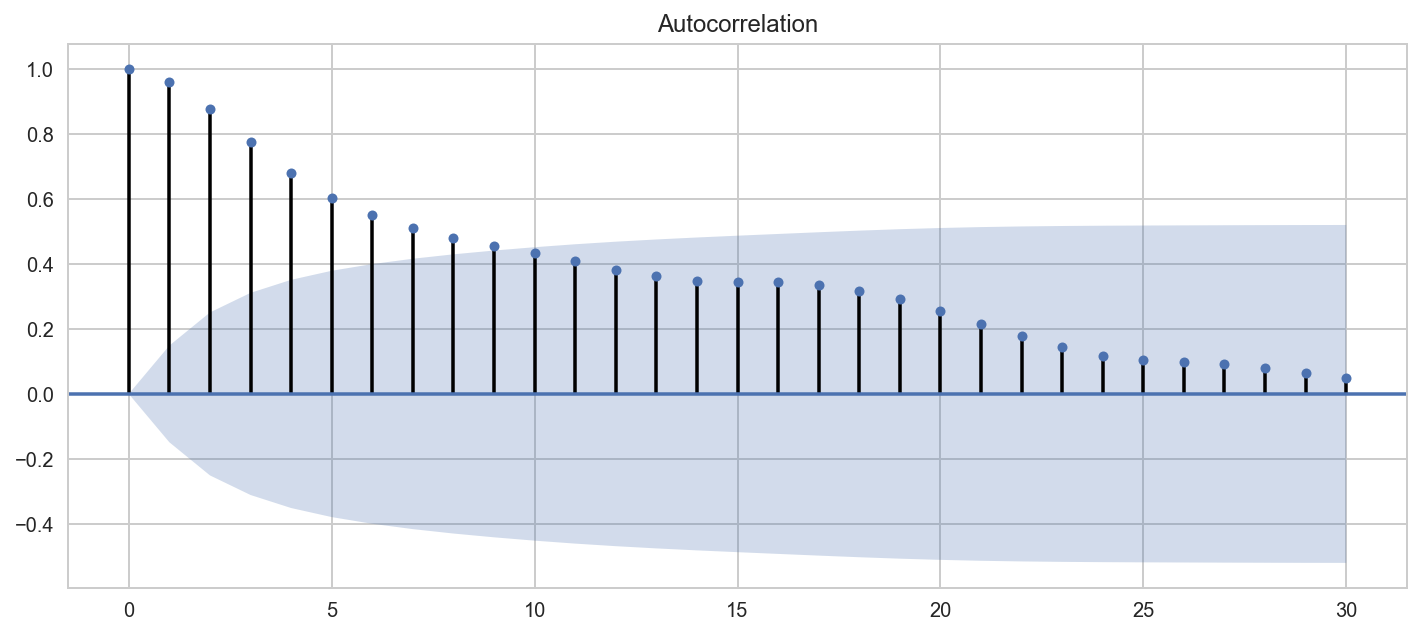

In [42]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(data.unemployment_rate.values, lags=30, ax=ax)
plt.show()

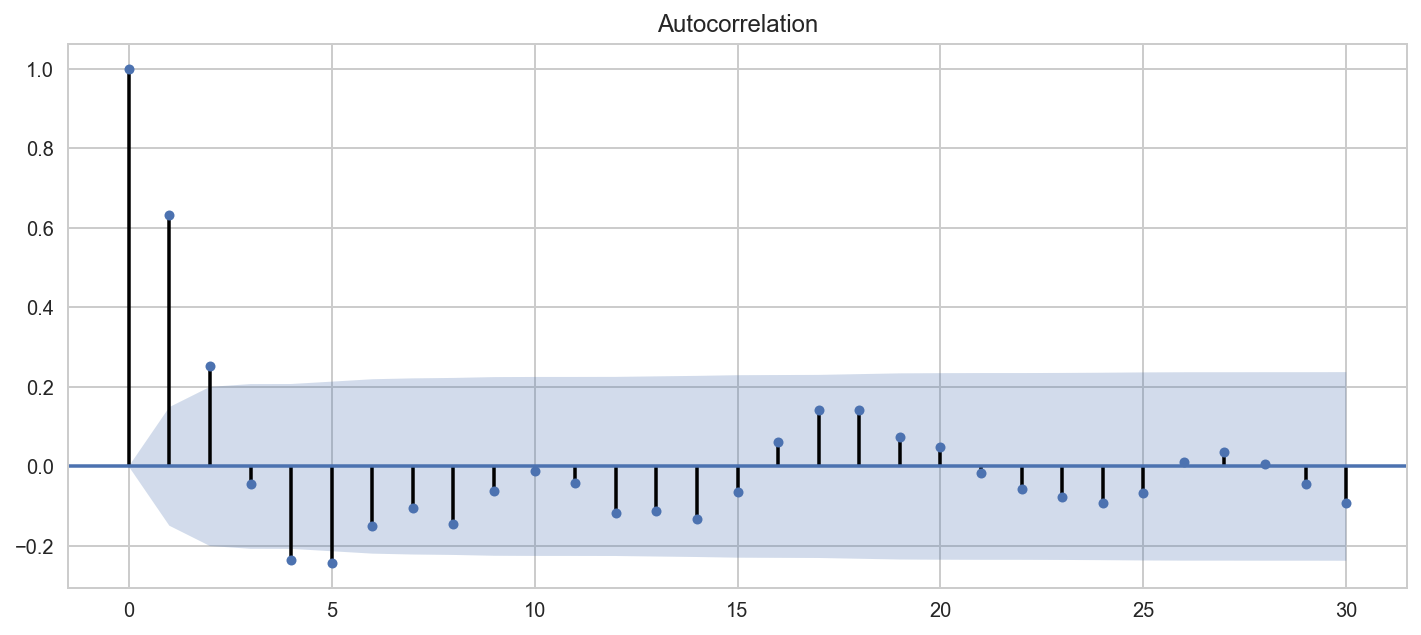

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(data.udiff.values[1:], lags=30, ax=ax)
plt.show()

**Computing Autocorrelation**

To compute autocorrelation, we fix a lag _k_ which is the delta between the given point and the prior point used to compute the correlation.

With a _k_ value of 1, we'd compute how correlated a value is with the prior one. With a _k_ value of 10, we'd compute how correlated a variable is with one 10 time points earlier.

---

### Partial autocorrelation and the partial autocorrelation function (PACF)

Another important chart to diagnose your timeseries is the partial autocorrelation chart (PACF). This is similar to the autocorrelation, but instead of just the correlation at increasing lags, it is the correlation at a given lag _controlling for the effect of previous lags._

In [46]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

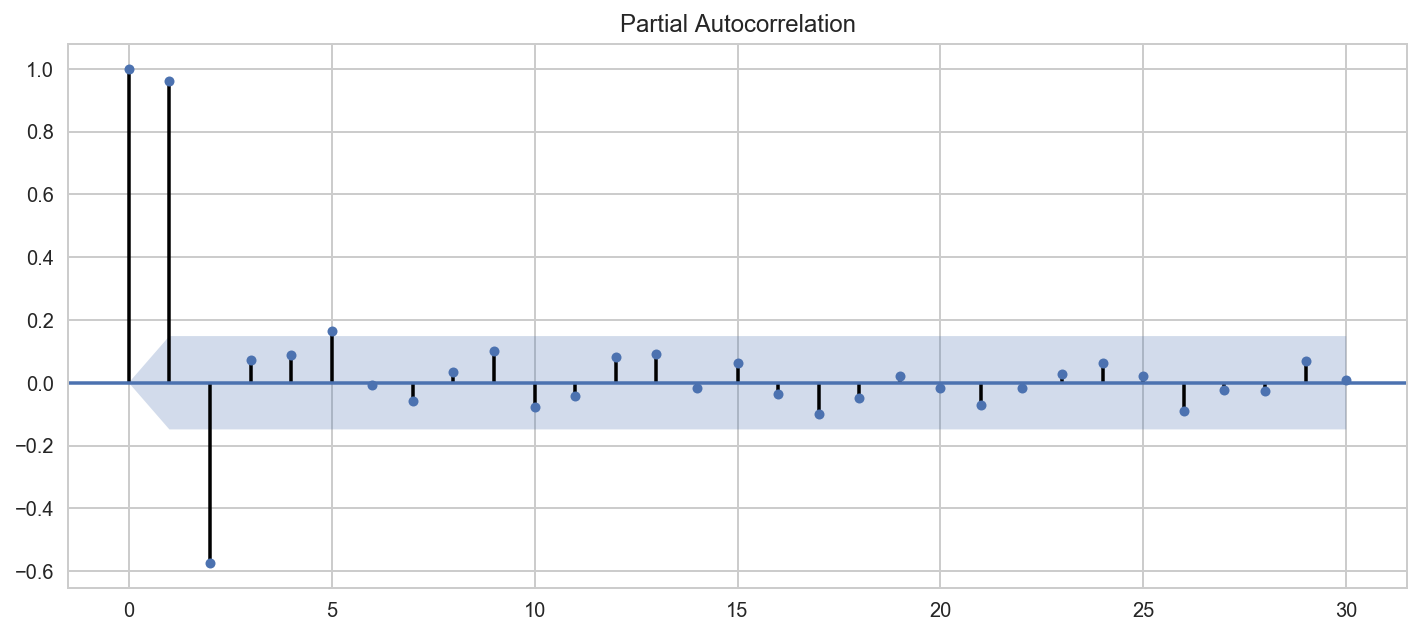

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(data.unemployment_rate.values, lags=30, ax=ax)
plt.show()

---

### Autoregressive (AR) models

Autoregressive (AR) models use data from previous time-points to predict the next time-point. These are essentially regression models where the predictors are previous timepoints of the outcome.

Typically, AR models are denoted `AR(p)`, where _p_ indicates the number of previous time points to incorporate. `AR(1)` is the most common.

In an autoregressive model we learn regression coefficients on the features that are the previous _p_ values.

### $$y_i = c + \beta_1  y_{i-1} + \beta_2  y_{i-2}\ +\ ...\ +\ \beta_p  y_{i-p}\ +\ \epsilon \\
y_i =\sum_{j=1}^p \beta_j y_{i-j} + \epsilon$$



In [4]:
from statsmodels.tsa.arima_model import ARMA
import pyflux as pf

---

### Moving Average (MA) models

**Moving average models** take previous _error terms_ as inputs. They predict the next value based on deviations from previous predictions. This can be useful for modeling a sudden occurrence - like something going out of stock affecting sales or a sudden rise in popularity.

As in autoregressive models, we have an order term, _q_, and we refer to our model as `MA(q)`.  This moving average model is dependent on the last _q_ errors. If we have a time series of sales per week, $y_i$, we can regress each $y_i$ on the last _q_ error terms.

### $$y_t = \epsilon_t + \beta_{1} \epsilon_{t-1} + ... \beta_{n} \epsilon_{t-n} \\
y_t = \sum_{i=1}^n \beta_i \epsilon_{t-i} + \epsilon_t$$

Sometimes the mean of the timeseries is included in the equation:

### $$ y_t = \mu + \sum_{i=1}^n \beta_i \epsilon_{t-i} + \epsilon_t $$

Moving average models are not as trivial to fit as autoregressive models because the error terms are unobserved. [There are a variety of different ways you can estimate the parameters, some of which are covered in this paper.](https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf)

In the simpler fitting procedures, a model is iteratively fit, errors are computed, then refit, over and over again until the parameters on the errors converge.

MA includes the mean of the time series. The behavior of the model is therefore characterized by random jumps around the mean value.

In an `MA(1)` model, there is one coefficient on the error of our previous prediction impacting our estimate for the next value in the timeseries.

---

## ARMA and ARIMA models

**ARMA** models combine the autoregressive models and moving average models. We combine both, parameterizing the behavior of the model with `p` and `q` terms corresponding to the `AR(p)` model and `MA(q)` model.

Autoregressive models slowly incorporate changes in preferences, tastes, and patterns. Moving average models base their prediction not on the prior value but the prior error, allowing us to correct sudden changes based on random events - supply, popularity spikes, etc.

**ARIMA** is just like the `ARMA(p, q)` model, but instead of predicting the value of the series it predicts the _differenced_ series or changes in the series. The order of differencing is set by an _d_ term as in `ARIMA(p, d, q)`, or alternatively you can just fit an `ARMA(p, q)` model on a differenced timeseries.

Recall the pandas `diff` function. This computes the difference between two consecutive values. In an ARIMA model, we attempt to predict this difference instead of the actual values.

### $$y_t - y_{(t-1)} = ARMA(p, q)$$

Timeseries are assumed to be "stationary" when modeling. This handles the stationarity assumption: instead of detrending or differencing manually, the model does this via the differencing term.

---

### How to choose the right `p` and `q` parameters.

In general it is never a bad idea to choose your parameters based on hold-out testing. That is to say, checking the performance of your model on future timepoints based on different choices of `p` and `q` for an ARIMA model.

However, you can get a sense for what parameters will work best based on the autocorrelation and partial autocorrelation charts.

[This site has a very detailed overview of how to use the acf and pacf to determine your parameters.](https://people.duke.edu/~rnau/411arim3.htm)

In general though, below are some basic guidelines. Remember that these rules apply to the ACF and PACF plots of differenced timeseries rather than the original timeseries (the exception being if your timeseries is stationary and does not require differencing):

1. If the PACF has a sharp cutoff and the lag-1 ACF value is positive then choose an AR(x) term where x is the lag in the PACF after the cutoff.
2. If the ACF has a sharp cutoff and the lag-1 ACF value is negative, choose an MA(x) term where x is the lag in the ACF after the cutoff.
3. If both the ACF and PACF show a gradual decay, and ARMA model is likely appropriate as opposed to the AR or MA alone.

Context 1 above corresponds to timeseries that are "underdifferenced" as indicated by a positive autocorrelation at lat 1. Likewise, context 2 is "overdifferenced" as indicated by the negative autocorrelation.

In general, you should try to choose an AR or MA model alone as opposed to an ARMA model. The AR and MA terms can work against each other in the model and create an overly-complex representation.